In [1]:
from torch.utils.data import DataLoader, Dataset
from imutils.paths import list_images
from collections import OrderedDict
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
import numpy as np
import torch
import os

/opt/conda/envs/tensor/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_PATH    = '/'.join(os.getcwd().split('/')[:-2])
DATASET_PATH = f'{ROOT_PATH}/dataset/UTKface'
IS_CUDA      = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 10
LR     = 1e-3
BS     = 64

device       = torch.device(IS_CUDA)
device

device(type='cuda')

In [3]:
digit2lb = {'gender' : {0 : 'male',  1 : 'female'},
            'race'   : {0 : 'White', 1 : 'Black', 2 : 'Asian', 3 : 'Indian', 4 : 'Others'}}

In [4]:
class UTKFace(Dataset):
    
    def __init__(self, image_paths):
        
        self.transform = transforms.Compose([
                            transforms.Resize((32, 32)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.486, 0.456, 0.406],
                                                [0.229, 0.224, 0.225])
                        ])
        
        self.image_paths = image_paths
        self.images      = []
        self.genders     = []
        self.races       = []
        self.ages        = []
        
        for idx, path in enumerate(image_paths, 1):
            filename = path.split('/')[-1].split("_")
            
            if len(filename) == 4:
                age, gender, race, _ = filename
                
                try:
                    self.genders.append(int(gender))
                    self.races.append(int(race))
                    self.ages.append(int(age))
                    self.images.append(path)
                    
                except:
                    print(f'[{idx}]. {path}')
                
                
    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(self.images[idx]).convert('RGB')
        image = self.transform(image)
        
        gender = self.genders[idx]
        race   = self.races[idx]
        age    = self.ages[idx]
        
        sample = {'image' : image, 'gender' : gender,
                 'race'   : race,  'age'    : age}
        
        return sample
        
        

In [5]:
train_image_paths = sorted(list_images(f'{DATASET_PATH}/train'))
valid_image_paths = sorted(list_images(f'{DATASET_PATH}/valid'))
test_image_paths  = sorted(list_images(f'{DATASET_PATH}/test'))

In [6]:
train_dataloader = DataLoader(UTKFace(train_image_paths), shuffle = True,  batch_size = BS)
valid_dataloader = DataLoader(UTKFace(valid_image_paths), shuffle = True,  batch_size = BS)
test_dataloader  = DataLoader(UTKFace(test_image_paths),  shuffle = False, batch_size = BS)

[9391]. /home/jovyan/TIL/dataset/UTKface/valid/53__0_20170116184028385.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

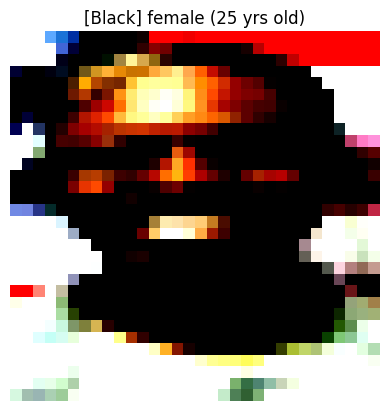

In [7]:
sample_data = next(iter(train_dataloader))

gender = int(sample_data['gender'][0].data)
image  = sample_data['image'][0]
race   = int(sample_data['race'][0].data)
age    = sample_data['age'][0]

plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f'[{digit2lb["race"][race]}] {digit2lb["gender"][gender]} ({age} yrs old)')
plt.axis(False)

In [8]:
class HydraNet(nn.Module):
    
    def __init__(self, net):
        
        super(HydraNet, self).__init__()
        self.net        = net
        self.n_features = self.net.fc.in_features
        self.net.fc     = nn.Identity()
        self.net.fc1    = nn.Sequential(
                            OrderedDict([
                                ('linear', nn.Linear(self.n_features, self.n_features)),
                                ('relu1' , nn.ReLU()),
                                ('final' , nn.Linear(self.n_features, 1))
                            ]))
        self.net.fc2    = nn.Sequential(
                            OrderedDict([
                                ('linear', nn.Linear(self.n_features, self.n_features)),
                                ('relu1' , nn.ReLU()),
                                ('final' , nn.Linear(self.n_features, 5))
                            ]))
        
        self.net.fc3   = nn.Sequential(
                            OrderedDict([
                                ('linear', nn.Linear(self.n_features, self.n_features)),
                                ('relu1' , nn.ReLU()),
                                ('final' , nn.Linear(self.n_features, 1))
                            ]))
        
        
    def forward(self, x):
        
        age_head    = self.net.fc1(self.net(x))
        race_head   = self.net.fc2(self.net(x))
        gender_head = self.net.fc3(self.net(x))
        
        return age_head, race_head, gender_head

In [9]:
net   = models.resnet34(pretrained = True)
model = HydraNet(net).to(device = device)

/opt/conda/envs/tensor/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/tensor/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
age_loss    = nn.L1Loss()
race_loss   = nn.CrossEntropyLoss()
gender_loss = nn.BCELoss()


optimizer   = torch.optim.SGD(model.parameters(), LR, momentum = 0.09)
sigmoid     = nn.Sigmoid()     

In [11]:
for epoch in range(1, EPOCHS + 1):
    
    model.train()
    train_loss = 0
    gender_acc = 0
    race_acc   = 0 

    print(f'[{epoch} / {EPOCHS}] training start')
    for idx, data in enumerate(tqdm(train_dataloader)):
        
        inputs    = data['image'].to(device = device)
        age_lb    = data['age'].to(device = device)
        race_lb   = data['race'].to(device = device)
        gender_lb = data['gender'].to(device = device)
        
        optimizer.zero_grad()
        
        age_output, race_output, gender_output = model(inputs)
        
        gender_pred = gender_output.max(1, keepdim = True)[1]
        race_pred   = race_output.max(1, keepdim = True)[1]
        
        gender_acc += gender_pred.eq(gender_lb.view_as(gender_pred)).sum().item()
        race_acc   += race_pred.eq(race_lb.view_as(race_lb)).sum().item()
        
        loss1 = age_loss(age_output, age_lb)
        loss2 = race_loss(race_output, race_lb)
        loss3 = gender_loss(sigmoid(gender_output), gender_lb.unsqueeze(1).float())
        loss  = loss1 + loss2 + loss3
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss
    
    train_loss /= len(train_dataloader.dataset)
    gender_acc /= len(train_dataloader.dataset)
    race_acc   /= len(train_dataloader.dataset)
    
    print(f'[{epoch} / {EPOCHS}] train_loss : {train_loss} gender acc : {gender_acc * 100:.2f} race acc : {race_acc * 100:.2f}')
    print('\n')
    

[1 / 10] training start


  0%|          | 0/159 [00:00<?, ?it/s]/opt/conda/envs/tensor/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 158/159 [01:26<00:00,  2.24it/s]/opt/conda/envs/tensor/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 159/159 [01:26<00:00,  1.84it/s]


[1 / 10] train_loss : 0.477714866399765 gender acc : 44.79 race acc : 1662.03
[2 / 10] training start


100%|██████████| 159/159 [01:25<00:00,  1.87it/s]


[2 / 10] train_loss : 0.45231932401657104 gender acc : 44.79 race acc : 3259.11
[3 / 10] training start


100%|██████████| 159/159 [01:24<00:00,  1.87it/s]


[3 / 10] train_loss : 0.43253374099731445 gender acc : 44.79 race acc : 3388.76
[4 / 10] training start


100%|██████████| 159/159 [01:25<00:00,  1.87it/s]


[4 / 10] train_loss : 0.41475045680999756 gender acc : 44.79 race acc : 3393.96
[5 / 10] training start


100%|██████████| 159/159 [01:24<00:00,  1.87it/s]


[5 / 10] train_loss : 0.3975462317466736 gender acc : 44.79 race acc : 3396.34
[6 / 10] training start


100%|██████████| 159/159 [01:24<00:00,  1.87it/s]


[6 / 10] train_loss : 0.3834778666496277 gender acc : 44.79 race acc : 3399.10
[7 / 10] training start


100%|██████████| 159/159 [01:24<00:00,  1.88it/s]


[7 / 10] train_loss : 0.37242963910102844 gender acc : 44.79 race acc : 3398.70
[8 / 10] training start


100%|██████████| 159/159 [01:24<00:00,  1.87it/s]


[8 / 10] train_loss : 0.3648986220359802 gender acc : 44.79 race acc : 3398.28
[9 / 10] training start


100%|██████████| 159/159 [01:24<00:00,  1.87it/s]


[9 / 10] train_loss : 0.36033183336257935 gender acc : 44.79 race acc : 3395.98
[10 / 10] training start


100%|██████████| 159/159 [01:25<00:00,  1.87it/s]

[10 / 10] train_loss : 0.3577789068222046 gender acc : 44.79 race acc : 3395.98
